In [2]:
# Smarter Circuits #
import imagePreprocessing as ip
import graphGeneration as gg
import componentClassification as cc
import matplotlib.pyplot as plt
import cv2
import utils

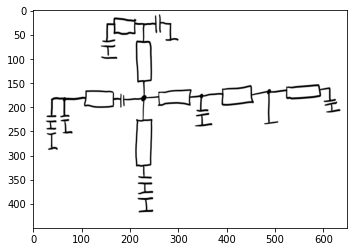

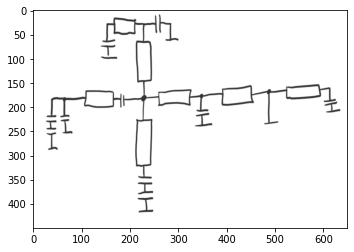

In [3]:
image = utils.loadImage(path="./../src/testImages",name="raf3.png")

colorImage = utils.loadImage(path="./../src/testImages",name="raf3.png", color=True)

plt.imshow(image, cmap='gray')
plt.figure()
plt.imshow(colorImage)

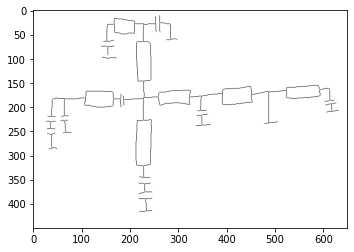

In [4]:
preprocessedImage = ip.preprocessImage(image)
utils.saveImage(name="preprocessed.png", image=preprocessedImage)

plt.imshow(preprocessedImage, cmap='gray')

In [5]:
def generateTrainData(boundingBoxes, image):
    components = []
    i = 0
    for box in boundingBoxes:
        component = image[box[0][1]:box[1][1], box[0][0]:box[1][0]]
        component = cv2.resize(component, (32,32), interpolation = cv2.INTER_AREA)
        utils.saveImage(name="{i}.png".format(i=i), image=component)
        i += 1

In [6]:
boundingBoxes = gg.generateBoudingBoxes(preprocessedImage)

#generateTrainData(boundingBoxes, image)
print(len(boundingBoxes))

In [ ]:
predictions = cc.classify(boundingBoxes, image)

print(predictions)

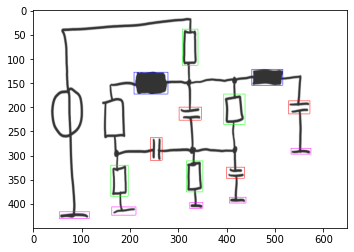

In [ ]:
for i in range(0, len(boundingBoxes)):
    if predictions[i] == "inductor":
        utils.drawRect(colorImage,boundingBoxes[i],(255,0,0))
    elif predictions[i] == "resistor":
        utils.drawRect(colorImage,boundingBoxes[i],(0,255,0))
    elif predictions[i] == "capacitor":
        utils.drawRect(colorImage,boundingBoxes[i],(0,0,255))
    elif predictions[i] == "ground":
        utils.drawRect(colorImage,boundingBoxes[i],(255,0,255))
    


colorImage = cv2.cvtColor(colorImage, cv2.COLOR_BGR2RGB)

plt.imshow(colorImage)

utils.saveImage(name="boundingBoxes.png", image=colorImage, color=True)